In [86]:
from typing import Tuple, Union, Dict, Optional, Iterator, Literal

import numpy as np
import sympy
from sympy import Basic, Pow, Symbol
from sympy import Expr, Eq, latex, plot_implicit, tan, cot, Ellipse
from sympy.core import S, pi, sympify, Equality
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
from sympy.plotting.plot import Plot
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

# Практическое занятие 14
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: гипербола

In [87]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self) -> Point:
        return self.args[0]

    @property
    def hradius(self) -> Expr:
        return self.args[1]
    
    @property
    def vradius(self) -> Expr:
        return self.args[2]
    @property
    def focus_distance(self) -> Expr:
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self) -> Expr:
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self) -> Expr:
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self) -> Tuple[Point, Point]:
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self) -> Expr:
        return self.hradius
    
    @property
    def minor(self) -> Expr:
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x: Union[Expr, Symbol] = _symbol(x, real=True)
        y: Union[Expr, Symbol] = _symbol(y, real=True)

        dx: Expr = x - self.center.x
        dy: Expr = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)
    
    def asymptote(
        self,
        x: Union[str, Expr, Symbol] = 'x',
        y: Union[str, Expr, Symbol] = 'y',
        equation: bool = False,
        _slope: Optional[Union[Expr, Symbol]] = None
    ) -> Union[Tuple[Equality, Equality], Tuple[Expr, Expr]]:
        if x is None:
            x: Union[Expr, Symbol] = _symbol('x', real=True)
        elif isinstance(x, str):
            x: Union[Expr, Symbol] = _symbol(x, real=True)
        if y is None:
            y: Union[Expr, Symbol] = _symbol('y', real=True)
        elif isinstance(y, str):
            y: Union[Expr, Symbol] = _symbol(y, real=True)
        
        b: Expr = self.minor
        a: Expr = self.major
        x0: Expr
        y0: Expr
        x0, y0 = self.center.args
        
        y_expr1: Expr
        y_expr2: Expr
        if _slope is None:
            arg: Expr = b / a * (x - x0)
            y_expr1 = y0 - arg
            y_expr2 = y0 + arg
            
        else:
            if not isinstance(_slope, (Expr, Symbol)):
                _slope = S(_slope)
            
            k1: Expr = (b + a*_slope)/(a - b*_slope)
            k2: Expr = (-b + a*_slope)/(a + b*_slope)
            y_expr1 = y0 + k1*(x - x0)
            y_expr2 = y0 + k2*(x - x0)
        
        return (Eq(y, y_expr1), Eq(y, y_expr2)) if equation else (y - y_expr1, y - y_expr2)
    
    def directrix(
        self,
        x: Union[str, Expr, Symbol] = 'x',
        equation: bool = False,
        _slope: Optional[Union[Expr, Symbol]] = None
    ) -> Union[Tuple[Equality, Equality], Tuple[Expr, Expr]]:
        if x is None:
            x: Union[Expr, Symbol] = _symbol('x', real=True)
        elif isinstance(x, str):
            x: Union[Expr, Symbol] = _symbol(x, real=True)

        a: Expr = self.major
        c: Expr = self.focus_distance
        div_arg: Expr = a*a/c
        x0: Expr
        y0: Expr
        x0, y0 = self.center.args

        if _slope is None:
            x_expr1: Expr = x0 - div_arg
            x_expr2: Expr = x0 + div_arg
            return (Eq(x, x_expr1), Eq(x, x_expr2)) if equation else (x - x_expr1, x - x_expr2)
        else:
            if _slope == S(0):
                raise ZeroDivisionError(_slope)
            
            ctg_alpha: Expr = 1 / _slope
            y_arg: Expr = y0 - (x - x0)*ctg_alpha
            
            ctg_arg: Expr = sqrt(1 + ctg_alpha)
            y_expr: Expr = div_arg * ctg_arg

            y_expr1: Expr = y_arg - y_expr
            y_expr2: Expr = y_arg + y_expr
            y: Union[Expr, Symbol] = _symbol('y', real=True)
            return (Eq(y, y_expr1), Eq(y, y_expr2)) if equation else (y - y_expr1, y - y_expr2)

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [88]:
Hyp1: Union[GeometrySet, Hyperbola] = Hyperbola(Point(1,2), hradius = 12, vradius = 5)
print(f'эксцентриситет: {Hyp1.eccentricity}')
print(f'фокусное расстояние: {Hyp1.focus_distance}')
print(f'фокусы: {Hyp1.foci}')
print(f'periapsis: {Hyp1.periapsis}')
display(Hyp1.equation(equation=True))

эксцентриситет: 13/12
фокусное расстояние: 13
фокусы: (Point2D(-12, 2), Point2D(14, 2))
periapsis: 1


Eq((x/12 - 1/12)**2 - (y/5 - 2/5)**2, 1)

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [89]:
display(*Hyp1.asymptote(x='u', y='v', equation=True))
display(*Hyp1.directrix(x='u', equation=True))

Eq(v, 29/12 - 5*u/12)

Eq(v, 5*u/12 + 19/12)

Eq(u, -131/13)

Eq(u, 157/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

(3*x + sqrt(3)*(y - 2) - 3)**2/1728 - (-3*y + sqrt(3)*(x - 1) + 6)**2/300 - 1

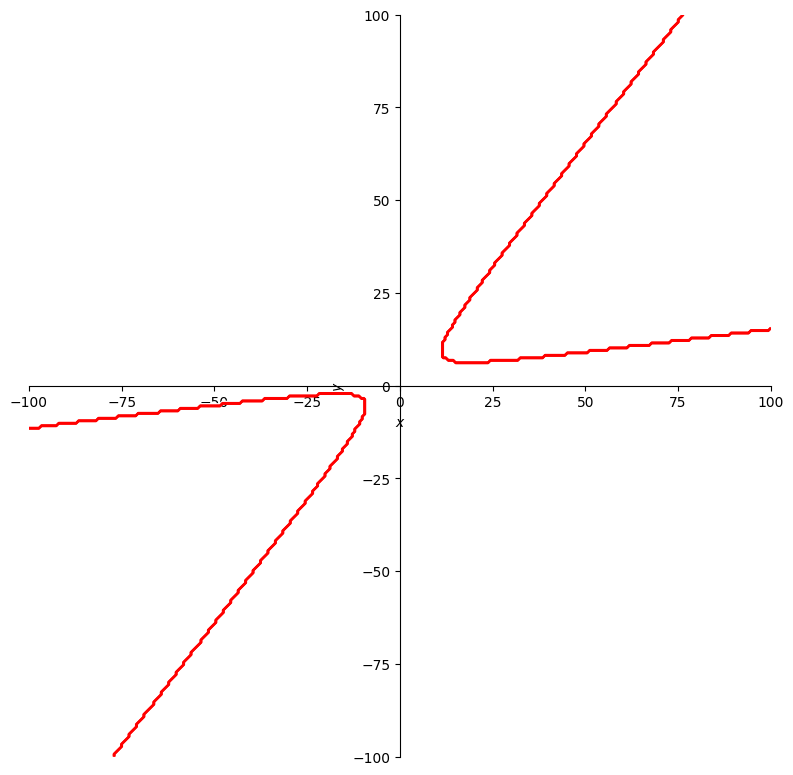

In [90]:
def degrees_to_rad(angle: Union[int, float, Basic]) -> Basic:
    return angle * sympy.pi / 180

slope = tan(degrees_to_rad(30))
hyp_eq = simplify(Hyp1.equation(_slope=slope), equation=True)
display(hyp_eq)
symbs: Dict[str, Basic] = {str(s): s for s in hyp_eq.free_symbols}
plot_implicit(
    hyp_eq,
    (symbs['x'], -100, 100),
    (symbs['y'], -100, 100),
    line_color='r',
    aspect_ratio=(1, 1),
    adaptive=False,
    size=(8, 8)
)
None

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

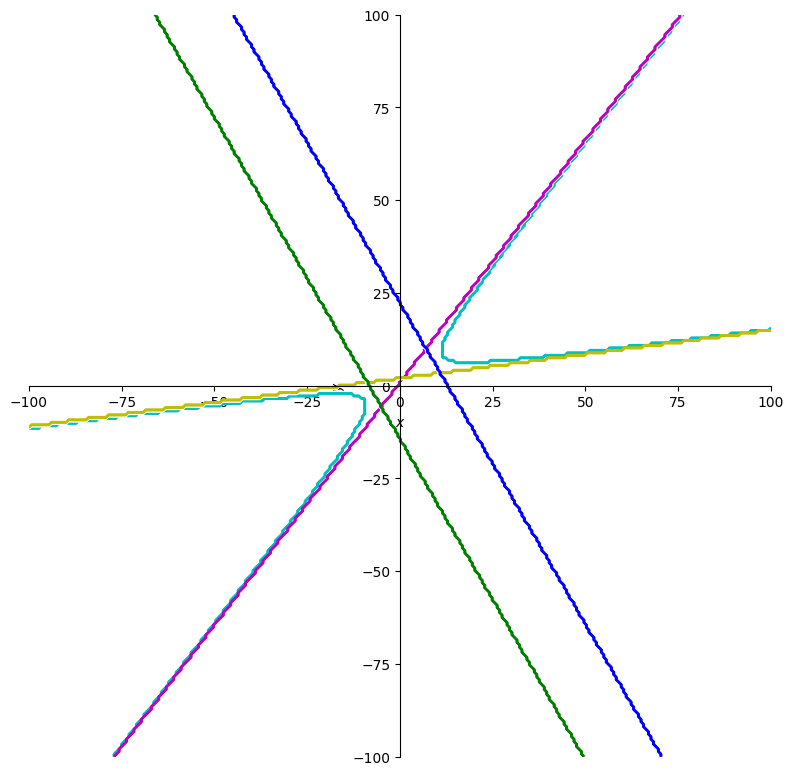

In [91]:
asymp_eqs: Tuple[Equality, Equality] = Hyp1.asymptote(equation=True, _slope=slope)
dir_eqs: Tuple[Equality, Equality] = Hyp1.directrix(equation=True, _slope=slope)
equations: Tuple[Equality, ...] = asymp_eqs + dir_eqs

hyp_eq = simplify(Hyp1.equation(_slope=slope))
symbs: Dict[str, Basic] = {str(s): s for s in hyp_eq.free_symbols}

p: Plot = plot_implicit(
    hyp_eq,
    (symbs['x'], -100, 100),
    (symbs['y'], -100, 100),
    line_color='c',
    aspect_ratio=(1, 1),
    show=False,
    adaptive=False,
    size=(8, 8)
)
colors_iterator: Iterator[Literal['m', 'y', 'g', 'b']] = iter(('m', 'y', 'g', 'b'))

for eq_i in equations:
    p.extend(plot_implicit(
        eq_i,
        (symbs['x'], -100, 100),
        (symbs['y'], -100, 100),
        line_color=next(colors_iterator),
        aspect_ratio=(1, 1),
        show=False,
        adaptive=False,
    ))

p.show()
    

In [92]:
from typing import overload, Union, Optional

@overload
def print_sympy_entity(text: Optional[str] = None) -> None:
    ...

@overload
def print_sympy_entity(text: Optional[str] = None, expression: Optional[Union[str, Basic]] = None, *, raw: bool = True) -> None:
    ...

@overload
def print_sympy_entity(text: Optional[str] = None, *expressions: Union[str, Basic], raw: bool = True) -> None:
    ...

def print_sympy_entity(*args, **kwargs) -> None:
    text: Optional[str] = kwargs.get("text", None)
    expression: Optional[Union[str, Basic]] = kwargs.get("expression", None)

    if text is None and args:
        text = args[0]
    
    expressions: list[str | Expr] = \
        [expr for expr in args[1:] if isinstance(expr, (str, Basic))] \
        if len(args) > 1 else []

    if expression is not None:
        expressions.append(expression)

    if not expressions:
        if text is not None:
            display(Latex("$\\text{" + text + "}$"))
        return
    
    is_raw: bool = kwargs.get("raw", True)
    if len(expressions) == 1:
        final_expr = '$' + (latex(expressions[0]) if is_raw else expressions[0]) + '$'
    else:
        final_expr: str = \
            r'$\\' + r'\\'.join(map(latex, expressions) if is_raw else expressions) + '$'

    if text is not None:
        final_expr = "$\\text{" + text + "}$ " + final_expr

    display(Latex(final_expr))


###  Индивидуальное задание
Определить гиперболу с центром в $(X, Y)$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнение повернутой гиперболы.

Вариант N 50

Центр $Point2D\left(5, -3\right)$, горизонтальная полуось $3$, эксцентриситет $3 / 2$, угол поворота $\pi / 6$, против часовой стрелки.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

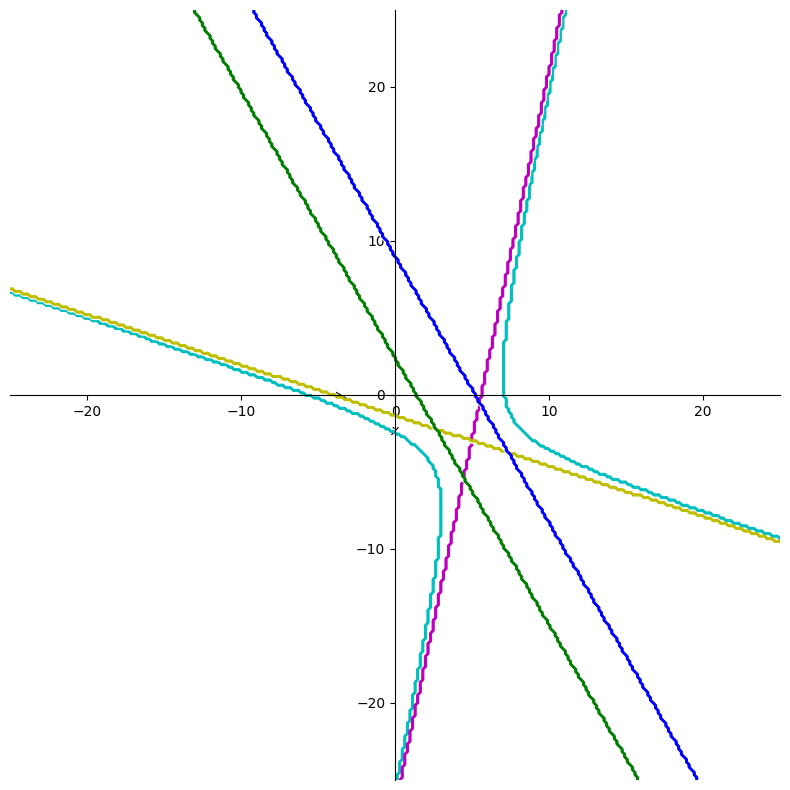

In [94]:
center: Point2D = Point2D(5, -3)
hradius: int = 3
eccentricity: Expr = S(3)/2
hyp: Hyperbola = Hyperbola(center=center, hradius=hradius, eccentricity=eccentricity)

print_sympy_entity("Эксцентриситет:", hyp.eccentricity)
print_sympy_entity("Фокусное расстояние:", hyp.focus_distance)
print_sympy_entity("Фокусы:", *hyp.foci)
print_sympy_entity("periapsis (периапсис):", hyp.periapsis)
print_sympy_entity("Уравнение гиперболы:", hyp.equation())
print_sympy_entity("Уравнения асимптот:", *hyp.asymptote(equation=True))
print_sympy_entity("Уравнения директрис:", *hyp.directrix(equation=True))

slope = tan(pi/6)
hyp_eq = simplify(hyp.equation(_slope=slope, equation=True))
symbs: Dict[str, Basic] = {str(s): s for s in hyp_eq.free_symbols}
print_sympy_entity("Уравнение повёрнутой гиперболы:", hyp_eq)

p: Plot = plot_implicit(
    hyp_eq,
    (symbs['x'], -25, 25),
    (symbs['y'], -25, 25),
    line_color='c',
    aspect_ratio=(1, 1),
    show=False,
    adaptive=False,
    size=(8, 8)
)
equations:  Tuple[Expr, ...] = hyp.asymptote(_slope=slope) + hyp.directrix(_slope=slope)
colors_iterator: Iterator[Literal['m', 'y', 'g', 'b']] = iter(('m', 'y', 'g', 'b'))

for eq_i in equations:
    p.extend(plot_implicit(
        eq_i,
        (symbs['x'], -25, 25),
        (symbs['y'], -25, 25),
        line_color=next(colors_iterator),
        aspect_ratio=(1, 1),
        show=False,
        adaptive=False,
    ))

p.show()